# Loading data and working with GrandPy objects


GrandPy is a Python package for the analysis of RNA-seq experiments involving metabolic RNA labeling with nucleotide conversion, such as SLAM-seq experiments [[Herzog et al. (2017)]](https://www.nature.com/articles/nmeth.4435). In such experiments, nucleoside analogs such as 4sU are added to living cells, which take it up and incorporate it into newly synthesized RNA. Before sequencing, 4sU is converted into a cytosin analog. Reads covering 4sU sites therefore have characteristic T-to-C mismatches after read mapping, in principle providing the opportunity to differentiate newly synthesized (during the time of labeling) from preexisting RNA.

Confounders such as sequencing errors or reads that originate from newly synthesized RNA but, by chance, do not cover sites of 4sU incorporation (usually 20-80% of all "new read") can be handled using specialized methods such as GRAND-SLAM [[Jürges et al. (2018)]](https://academic.oup.com/bioinformatics/article/34/13/i218/5045735?login=true).

# Reading in the data

Throughout this notebook, we will be using the GRAND-SLAM processed SLAM-seq data set from [Finkel et al. (2021)](https://www.nature.com/articles/s41586-021-03610-3). The data set contains time series (progressive labeling) samples from a human epithelial cell line (Calu3 cells); half of the samples were infected with SARS-CoV-2 for different periods of time.

The output of GRAND-SLAM is a tsv file where rows are genes and columns are read counts and other statistics (e.g., the new-to-total RNA ratio) for all samples. The data set is available on zenodo ("https://zenodo.org/record/5834034/files/sars.tsv.gz"). We start by reading this file into Python:

In [23]:
import warnings
import grandpy as gp
from grandpy import read_grand

warnings.filterwarnings("ignore", category=UserWarning)

sars = read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"))
print(sars.columns)

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.
['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A', 'SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


When reading in the file, we have to define the `design`. This is used to infer metadata automatically from sample names. Here sample names consist of three parts separated by dots as shown above. Each part in the sample name represents an aspect of the `design`. For example, the sample named 'Mock.2h.A' is a sample from the mock condition (i.e. not infected by SARS-CoV-2), subjected to metabolic labeling for 2 hours, and is the first replicate (i.e. replicate "A"). This sample name is consistent with the three element `design` used above. It is possible to specify other design elements (of course the samples would have to be named accordingly). A list of reasonable options is predefined in the dictionary `DESIGN_KEYS`.

There are names (i.e. the things you specify in the design vector) that have additional semantics. For example, for the name 'duration.4sU' the values are interpreted like this: 4h is converted into the number 4, 30min into 0.5, and no4sU into 0. For more information, see Paragraph **Column Metadata**). The design vector is mandatory. Attempting to read in the data without it results in an error:

In [24]:
try:
    sars_wrong = read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz")
except Exception as e:
    print(e)

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Design must be specified.


Alternatively, a table containing the metadata can be specified. Make sure that it contains a *Name* column matching the names in the GRAND-SLAM output table:

In [25]:
import pandas as pd

metadata = pd.DataFrame({
    "Name": [
        "Mock.no4sU.A","Mock.1h.A","Mock.2h.A","Mock.2h.B",
        "Mock.3h.A","Mock.4h.A","SARS.no4sU.A","SARS.1h.A",
        "SARS.2h.A","SARS.2h.B","SARS.3h.A","SARS.4h.A"
    ],
    "Condition": ["Mock"] * 6 + ["SARS"] * 6
})

sars_meta = read_grand("../../grandpy/data/sars.tsv", design=metadata)
print(sars_meta)

Detected dense format -> using dense reader
GrandPy:
Read from C:\Users\user\PycharmProjects\grandpy\grandpy\data\sars.tsv
19659 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



### What is the GrandPy object

`read_grand()` returns a GrandPy object, which contains
- Metadata for genes (gene_info)
- Metadata for samples/cells (as inferred from the sample names by the design parameter) (coldata)
- Data matrices (counts, normalized counts, ntrs, etc.) (slots)
- Analysis results (analyses)
- Plot functions (plots)

'gene_info' and 'coldata' are described below. How to work with the data matrices and analysis results is described in a separate [notebook](../notebook_04_working_with_data_matrices_and_analysis_results).

# Working with GrandPy objects

Here we will see how to work with GrandPy objects in general. A short summary can be displayed when printing the object, and there are several methods and properties to retrieve general information about the object:

In [26]:
print(sars)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpxfaf07so\sars.tsv.gz
19659 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count']
Available analyses: []
Available plots: {}
Default data slot: count



In [27]:
sars.title

'sars.tsv.gz'

In [28]:
len(sars.genes)

19659

In [29]:
len(sars.columns)

12


It is straight-forward to filter genes:

In [30]:
sars = sars.filter_genes()
len(sars.genes)

9162

By default genes are retained if they have 100 read counts in at least half of the samples (or cells). There are many options how to filter by genes (note that `filter_genes()` returns a new GrandPy object, and below we directly call `len()` on this new object to check how many genes are retained by filtering):

In [31]:
print(f"Genes with at least 1000 read counts in half of the columns: {len((sars.filter_genes(min_expression=1000)))}")

Genes with at least 1000 read counts in half of the columns: 1528


In [32]:
print(f"Genes with at least 1000 read counts in half of the columns (retain two genes that are otherwise filtered): {len((sars.filter_genes(min_expression=1000, keep=["ATF3", "ZC3H12A"])))}")

Genes with at least 1000 read counts in half of the columns (retain two genes that are otherwise filtered): 1530


In [33]:
print(f"Keep only these two genes: {len((sars.filter_genes(use=["ATF3", "ZC3H12A"])))}")

Keep only these two genes: 2


In [34]:
sars = sars.normalize_tpm()
print("Genes with at least 10 TPM in half of the columns:", len(sars.filter_genes(mode_slot="tpm", min_expression=10, min_columns=sars.coldata.shape[0]/2)))


Genes with at least 10 TPM in half of the columns: 7795


`filter_genes()` essentially removes rows from the data slots. It is also possible to remove columns (and rows) using subsetting. The rules for subsetting are similar to that of a pandas DataFrame and identical to Anndata. You can use the index labels from `coldata`/`gene_info`, boolean masks, or index integer.

In [35]:
mock = sars[:, sars.coldata["Condition"] == "Mock"]
print(mock)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpxfaf07so\sars.tsv.gz
9162 genes, 6 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: tpm



The new GrandPy object now only has 6 columns. A closely related function is `split()`, which returns a list of several GrandPy objects, each composed of samples having the same value in the `coldata` column specified in the parameter `by`.

In [36]:
condition1, condition2 = sars.split(by="Condition")
print(condition1, "\n", condition2)

GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpxfaf07so\sars.tsv.gz
9162 genes, 6 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: tpm
 
 GrandPy:
Read from C:\Users\user\AppData\Local\Temp\tmpxfaf07so\sars.tsv.gz
9162 genes, 6 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count', 'tpm']
Available analyses: []
Available plots: {}
Default data slot: tpm



In [37]:
print(condition1.columns, "\n", condition2.columns)

['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A'] 
 ['SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


The inverse of `split()` is `concat()`:

In [38]:
merged = gp.concat([condition1, condition2])
print(merged.columns)

['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A', 'SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


 `merge()` can also be used in a very similar fashion:

In [39]:
merged = condition1.merge(condition2)
print(merged.columns)

['Mock.no4sU.A', 'Mock.1h.A', 'Mock.2h.A', 'Mock.2h.B', 'Mock.3h.A', 'Mock.4h.A', 'SARS.no4sU.A', 'SARS.1h.A', 'SARS.2h.A', 'SARS.2h.B', 'SARS.3h.A', 'SARS.4h.A']


Finally, the object can be saved as a file and later retrieved.

In [40]:
merged.write_h5ad("./merged_sars_dataset.h5ad")

In [41]:
saved_sars = gp.read_h5ad("./merged_sars_dataset.h5ad")

In [42]:
import os

# Here we remove the file again, as this is just a demonstration.
os.remove("./merged_sars_dataset.h5ad")

# Gene metadata

Here we see how to work with metadata for genes. The gene metadata essentially is a table that can be retrieved using `gene_info`:

In [43]:
sars.gene_info.head(10)

,Symbol,Gene,Length,Type
Symbol,,,,
MIB2,MIB2,ENSG00000197530,4247,Cellular
OSBPL9,OSBPL9,ENSG00000117859,4520,Cellular
BTF3L4,BTF3L4,ENSG00000134717,4703,Cellular
ZFYVE9,ZFYVE9,ENSG00000157077,5194,Cellular
PRPF38A,PRPF38A,ENSG00000134748,5274,Cellular
AHCYL1,AHCYL1,ENSG00000168710,4313,Cellular
ADGRL2,ADGRL2,ENSG00000117114,6302,Cellular
HOOK1,HOOK1,ENSG00000134709,5857,Cellular
NFIA,NFIA,ENSG00000162599,9487,Cellular


Each gene has associated ensemble IDs (*Name*) and symbols (*Symbol*). IDs and symbols as well as the transcript length are part of GRAND-SLAM output. The *Type* column is inferred automatically (see below).

Genes can be retrieved with `genes` & `get_genes()`:

In [44]:
print(sars.genes[:20])

['MIB2', 'OSBPL9', 'BTF3L4', 'ZFYVE9', 'PRPF38A', 'AHCYL1', 'ADGRL2', 'HOOK1', 'NFIA', 'PATJ', 'VANGL1', 'GPR89B', 'GPSM2', 'ARHGEF10L', 'TMEM50A', 'TMEM57', 'ZNF593', 'RNF207', 'ZNF362', 'STX12']


In [45]:
print(sars.get_genes(get_gene_symbols=False)[:20])

['ENSG00000197530', 'ENSG00000117859', 'ENSG00000134717', 'ENSG00000157077', 'ENSG00000134748', 'ENSG00000168710', 'ENSG00000117114', 'ENSG00000134709', 'ENSG00000162599', 'ENSG00000132849', 'ENSG00000173218', 'ENSG00000188092', 'ENSG00000121957', 'ENSG00000074964', 'ENSG00000183726', 'ENSG00000204178', 'ENSG00000142684', 'ENSG00000158286', 'ENSG00000160094', 'ENSG00000117758']


'ORF1ab' is one of the viral genes in this dataset and doesn't have an ensemble ID.

In [46]:
print(sars.get_genes(genes=["MYC", "ORF1ab"],get_gene_symbols=False)[:20])

['ENSG00000136997', 'ORF1ab']


In [47]:
print(sars.get_genes(genes="YC", regex=True))

['NFYC', 'MYCBP', 'PYCR2', 'GLYCTK', 'FYCO1', 'CYCS', 'CYC1', 'MYC', 'PYCR3', 'MYCBP2', 'MLYCD', 'PYCR1', 'SYCP2']


During reading the data into Python using `read_grand()`, the *Type* column is inferred using the `classify_genes()` function. By default, this will recognize mitochondrial genes (MT prefix of the gene symbol), ERCC spike-ins, and Ensembl gene identifiers (which it will call "cellular"). Here we also have the viral genes, which are not properly recognized:

In [48]:
print(sars.gene_info["Type"].value_counts())

Type
Cellular    9151
Unknown       11
Name: count, dtype: int64


If you want to define your own types, you can do this easily via `classification_genes`, `classification_genes_label` and `classify_genes_func` parameter when read in your data:

In [49]:
viral_genes = ['ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10','ORF1ab','S']
sars = read_grand("../../grandpy/data/sars_R.tsv", design=("Condition", "dur.4sU", "Replicate"), classification_genes=viral_genes, classification_genes_label="viral")

print(sars.gene_info["Type"].value_counts())
print(f"Classified Genes: {sars.get_classified_genes("viral")}")

Detected dense format -> using dense reader
Type
Cellular    1034
viral         11
Name: count, dtype: int64
Classified Genes: ['ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF10', 'ORF1ab', 'S']


Note that each gene has to be specified explicitly.

The `classify_genes` function has one additional important parameter, which defines how "Unknown" types are supposed to be called. For this data set, the same result can be achieved using this:

In [50]:
sars = read_grand("../../grandpy/data/sars_R.tsv", design=("Condition", "dur.4sU", "Replicate"), classify_genes_func=lambda df: gp.classify_genes(df, cg_name="viral"))
sars.gene_info["Type"].value_counts()

print(sars.gene_info["Type"].value_counts())
print(f"Classified Genes: {sars.get_classified_genes("viral")}")

Detected dense format -> using dense reader
Type
Cellular    1034
viral         11
Name: count, dtype: int64
Classified Genes: ['ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF10', 'ORF1ab', 'S']


It is also straight-forward to add additional gene metadata:

In [51]:
import numpy as np

sars = sars.with_gene_info(name="length.category",value=pd.cut(
    sars.gene_info["Length"],
    bins=[0, 2000, 5000, np.inf],
    labels=["Short", "Medium", "Long"]
))

sars.gene_info["length.category"].value_counts()

length.category
Medium    482
Long      422
Short     141
Name: count, dtype: int64

# Column Metadata

Samples for bulk experiments and cells in single cell experiments are in GrandPy jointly called "columns". The metadata for columns is a table that describes the experimental design we specified when reading in data in GrandPy. It can be accessed via `coldata`. We can also see that the duration of 4sU has been interpreted and converted to a numeric value (compare "duration.4sU" with "duration.4sU.original").

In [52]:
sars.coldata

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU
Name,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False


Additional semantics can also be defined. This is done automatically inside the function `build_coldata()`, which assigns a dictionary to the attribute `.attrs["_semantics"]` of the `coldata` DataFrame. This dictionary helps interpret certain design columns (e.g. time, concentration).

An important part of this mechanism is the conversion of time-like values (such as `'5h'`, `'30min'`, or `'no4sU'`) into numeric hours. GrandPy provides a dedicated function for this: `parse_time_string`, which handles strings and returns hours as float.

In [53]:
print(gp.semantics_time(["5h", "30min", "no4sU"], "Test"))

   Test Test.original
0   5.0            5h
1   0.5         30min
2   0.0         no4sU


We can easily define our own function like this:

In [54]:
from grandpy.load import parse_time_string

def my_semantics_time(values, name):
    df = pd.DataFrame({name: values})
    if not np.issubdtype(df[name].dtype, np.number):
        df[f"{name}.original"] = df[name]
        df[name] = df[name].map(parse_time_string)
    else:
        df[f"{name}.original"] = df[name]  # falls schon float
    h = df[name] + 3

    def fmt(x):
        return f"{int(x) if x.is_integer() else x}hpi"

    df["hpi"] = h.map(fmt)
    df.attrs["_semantics"] = {"hpi": "time"}
    return df

print(my_semantics_time(["5h", "30min", "no4sU"], "Test"))

   Test Test.original     hpi
0   5.0            5h    8hpi
1   0.5         30min  3.5hpi
2   0.0         no4sU    3hpi


Here, it is important to note that at 3 hours post infection, 4sU was added to the cells for 1, 2, 3, or 4 hours.
The two no4sU samples were also collected at 3 hpi.
This custom time transformation function can now be used as the `semantics` parameter in `read_grand`, like so:

In [55]:
sars_meta = read_grand("../../grandpy/data/sars.tsv", design=("Cell", "dur.4sU", "Replicate"), semantics={"duration.4sU": my_semantics_time})

Detected dense format -> using dense reader


As mentioned above, it is in most cases easier to add additional metadata after loading.The infection time point can also be added by:

In [56]:
hpi_series = sars.coldata["duration.4sU"].apply(lambda x: f"{x + 3}hpi")
sars = sars.with_coldata(name="hpi", value=hpi_series)
sars.coldata

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,hpi
Name,,,,,,,
Mock.no4sU.A,Mock.no4sU.A,Mock,0.0,no4sU,A,True,3.0hpi
Mock.1h.A,Mock.1h.A,Mock,1.0,1h,A,False,4.0hpi
Mock.2h.A,Mock.2h.A,Mock,2.0,2h,A,False,5.0hpi
Mock.2h.B,Mock.2h.B,Mock,2.0,2h,B,False,5.0hpi
Mock.3h.A,Mock.3h.A,Mock,3.0,3h,A,False,6.0hpi
Mock.4h.A,Mock.4h.A,Mock,4.0,4h,A,False,7.0hpi
SARS.no4sU.A,SARS.no4sU.A,SARS,0.0,no4sU,A,True,3.0hpi
SARS.1h.A,SARS.1h.A,SARS,1.0,1h,A,False,4.0hpi
SARS.2h.A,SARS.2h.A,SARS,2.0,2h,A,False,5.0hpi


There are also some build-in GrandPy methods that add metadata, such as `compute_expression_percentage()`:

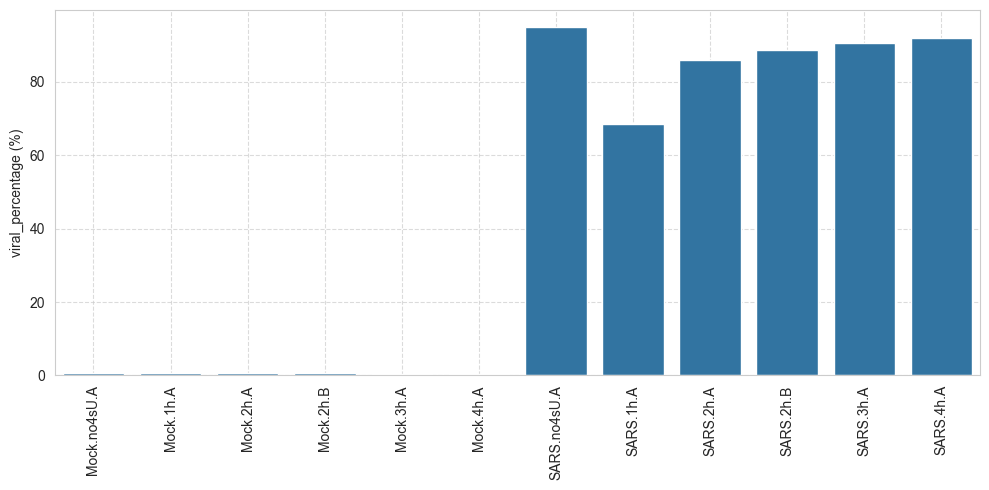

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sars = sars.compute_expression_percentage(name="viral_percentage", genes=(sars.gene_info["Type"]=="viral"))

df = sars.coldata.copy()
df["Sample"] = df.index

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df, x="Sample", y="viral_percentage", ax=ax)
ax.set_axisbelow(True)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.grid(axis="x", linestyle="--", alpha=0.7)
ax.tick_params(axis="x", rotation=90)
plt.subplots_adjust(bottom=0.3)
ax.set_xlabel("")
ax.set_ylabel("viral_percentage (%)")
plt.tight_layout()
plt.show()


Interestingly, the 4sU-naive sample shows more viral gene expression, suggesting that 4sU affected viral gene expression.

Since this is such an important control, there is also a specialized plotting built for that:

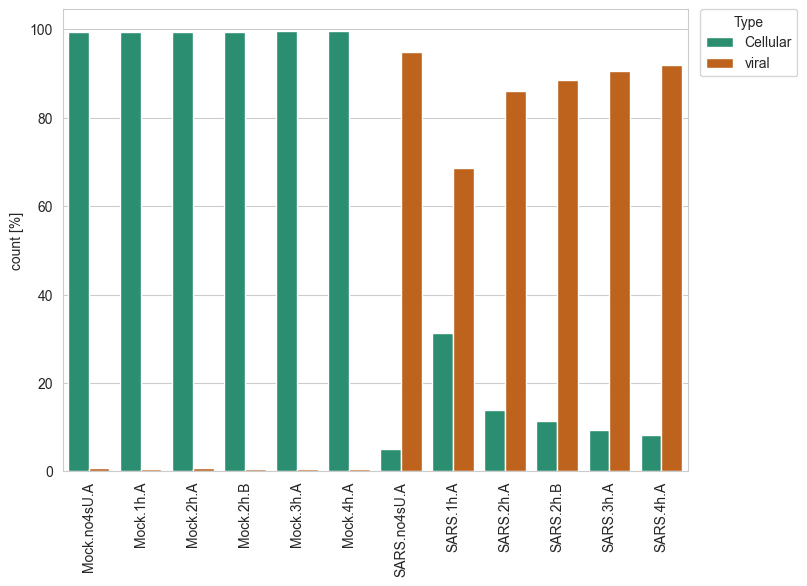

In [58]:
gp.plot_type_distribution(sars, relative=True)

There is a column in the `coldata` that has a special meaning: *Condition*. It is used by many functions as a default, e.g. to plot colors in the PCA or to model kinetics per conditions. It can be accessed by its own property:

In [59]:
print(sars.condition)

['Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS']


and it can either be set directly:

In [60]:
sars = sars.with_coldata(name="saved", value=sars.condition)
new_conditions = ["control"] * 6 + ["infected"] * 6
sars = sars.with_condition(new_conditions)
sars.coldata

,Name,Condition,duration.4sU,duration.4sU.original,Replicate,no4sU,hpi,viral_percentage,saved
Name,,,,,,,,,
Mock.no4sU.A,Mock.no4sU.A,control,0.0,no4sU,A,True,3.0hpi,0.677886,Mock
Mock.1h.A,Mock.1h.A,control,1.0,1h,A,False,4.0hpi,0.536348,Mock
Mock.2h.A,Mock.2h.A,control,2.0,2h,A,False,5.0hpi,0.663292,Mock
Mock.2h.B,Mock.2h.B,control,2.0,2h,B,False,5.0hpi,0.539084,Mock
Mock.3h.A,Mock.3h.A,control,3.0,3h,A,False,6.0hpi,0.488723,Mock
Mock.4h.A,Mock.4h.A,control,4.0,4h,A,False,7.0hpi,0.471347,Mock
SARS.no4sU.A,SARS.no4sU.A,infected,0.0,no4sU,A,True,3.0hpi,94.831056,SARS
SARS.1h.A,SARS.1h.A,infected,1.0,1h,A,False,4.0hpi,68.642115,SARS
SARS.2h.A,SARS.2h.A,infected,2.0,2h,A,False,5.0hpi,86.023690,SARS


or from one or several columns of the coldata (here this is not really reasonable, but there are situations where combining more than one coldata column makes sense):

In [61]:
sars = sars.with_condition(["saved", "Replicate"])
print(sars.condition)

['Mock A', 'Mock A', 'Mock A', 'Mock B', 'Mock A', 'Mock A', 'SARS A', 'SARS A', 'SARS A', 'SARS B', 'SARS A', 'SARS A']


In [62]:
sars = sars.with_condition("saved")
print(sars.condition)

['Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS', 'SARS']


# Working with the data by yourself

There are several functions designed to give more access to the data.

Let's stick with the `coldata` for now. You could also set a new `condition` by replacing the entire `coldata`:

In [63]:
col = sars.coldata
col["Condition"] = ['Mock A', 'Mock A', 'Mock A', 'Mock B', 'Mock A', 'Mock A', 'SARS A', 'SARS A', 'SARS A', 'SARS B', 'SARS A', 'SARS A']
sars = sars.with_replaced_parameters(coldata=col)
print(sars.condition)

['Mock A', 'Mock A', 'Mock A', 'Mock B', 'Mock A', 'Mock A', 'SARS A', 'SARS A', 'SARS A', 'SARS B', 'SARS A', 'SARS A']


There is actually one more method for accessing the slot data: `get_matrix()`. It returns the data as it is stored internally, if `force_numpy` is set to False (numpy ndarray for bulk or scipy csr_matrix for single-cell). Subsetting `genes` and `columns` works just like before, but `mode_slot` can only be a single slot here.

Note that usually entire parts are replaced by `with_replaced_parameters`. Slots are the exception, as it is possible to replace a single slot.

In [64]:
n_count = sars.get_matrix(mode_slot="new_count", force_numpy=False)
n_count[0:5]

array([[   0.        ,  201.79815   ,  434.8188    ,  687.4245    ,
        1619.244     , 1653.73155662,    0.        ,  123.6175    ,
         377.5891    ,  739.3707    ,  275.487     ,  463.9306    ],
       [   0.        ,  118.6468    ,   81.9735    ,  106.63275   ,
         130.0816    ,  111.0798    ,    0.        ,  109.323     ,
         318.5       ,  305.        ,  221.        ,  357.5       ],
       [   0.        ,  531.0885    , 1197.08492629,  876.276     ,
        2252.72105723, 2245.743     ,    0.        ,  255.2004    ,
         958.4425    , 1094.9271    ,  466.4796    ,  609.994     ],
       [   0.        ,  187.77025215,  633.77505   ,  651.8127    ,
        1378.364     , 1745.7635    ,    0.        ,  113.807     ,
         365.27030043,  532.9281    ,  271.662     ,  639.4415    ],
       [   0.        ,  129.36375   ,  725.2245    ,  849.78038116,
        1810.40003933, 2004.82149224,    0.        ,  114.523     ,
         674.94110757,  828.17454882,  451.6

In [65]:
temp_sars = sars.with_replaced_parameters(count=n_count)
temp_sars.get_matrix("count")[0:5]

array([[   0.        ,  201.79815   ,  434.8188    ,  687.4245    ,
        1619.244     , 1653.73155662,    0.        ,  123.6175    ,
         377.5891    ,  739.3707    ,  275.487     ,  463.9306    ],
       [   0.        ,  118.6468    ,   81.9735    ,  106.63275   ,
         130.0816    ,  111.0798    ,    0.        ,  109.323     ,
         318.5       ,  305.        ,  221.        ,  357.5       ],
       [   0.        ,  531.0885    , 1197.08492629,  876.276     ,
        2252.72105723, 2245.743     ,    0.        ,  255.2004    ,
         958.4425    , 1094.9271    ,  466.4796    ,  609.994     ],
       [   0.        ,  187.77025215,  633.77505   ,  651.8127    ,
        1378.364     , 1745.7635    ,    0.        ,  113.807     ,
         365.27030043,  532.9281    ,  271.662     ,  639.4415    ],
       [   0.        ,  129.36375   ,  725.2245    ,  849.78038116,
        1810.40003933, 2004.82149224,    0.        ,  114.523     ,
         674.94110757,  828.17454882,  451.6

It is also possible to retrieve the AnnData from a GrandPy object.

In [66]:
sars.to_anndata()

AnnData object with n_obs × n_vars = 1045 × 12
    obs: 'Symbol', 'Gene', 'Length', 'Type', 'length.category'
    var: 'Name', 'Condition', 'duration.4sU', 'duration.4sU.original', 'Replicate', 'no4sU', 'hpi', 'viral_percentage', 'saved'
    uns: 'prefix', 'metadata', 'analyses', 'plots'
    layers: 'ntr', 'alpha', 'beta', 'count'

Note that the AnnData is transposed, relative to what you would usually expect. Meaning `obs` is here the `gene_info` and `var` is the `coldata`.
To make it scanpy compatible use `transpose` = True. X can also be set via `x`.

In [67]:
adata = sars.to_anndata(x="count", transpose=True)
adata

AnnData object with n_obs × n_vars = 12 × 1045
    obs: 'Name', 'Condition', 'duration.4sU', 'duration.4sU.original', 'Replicate', 'no4sU', 'hpi', 'viral_percentage', 'saved'
    var: 'Symbol', 'Gene', 'Length', 'Type', 'length.category'
    uns: 'prefix', 'metadata', 'analyses'
    layers: 'ntr', 'alpha', 'beta', 'count'

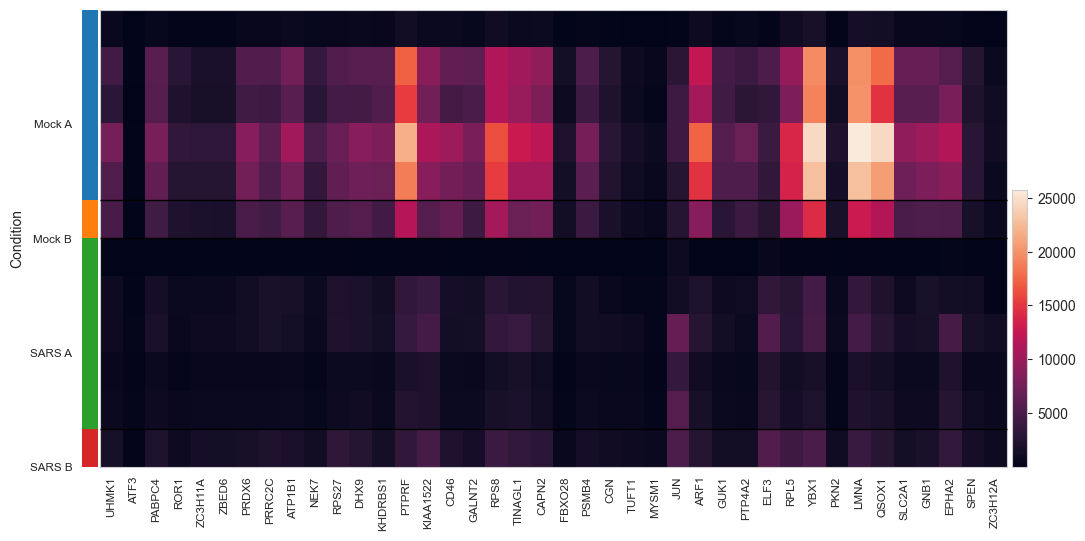

In [68]:
import scanpy as sc

sc.pl.heatmap(adata, var_names=adata.var_names[0:40], groupby='Condition')

The AnnData can also be transformed back into a GrandPy object, paying attention to the orientation.

In [69]:
gp.anndata_to_grandpy(adata, transpose=True)

GrandPy object: 1045 genes, 12 samples/cells
Available data slots: ['ntr', 'alpha', 'beta', 'count'], default: count
Available analyses: []
Available plots: {}